In [ ]:
from glob import glob

glob.glob("/content/drive/MyDrive/data/finetune-news/")

## Exploratory Analysis

In [1]:
%load_ext autoreload
%autoreload 2
import os
from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets()

#train_dataset = train_dataset.select(range(500))

Veamos algunos ejemplos

In [2]:
from hatedetection import hate_categories
subset = train_dataset.select(range(100, 200))

for example in subset:
    print("="*80)
    print("Contexto:", example["context"])
    print("Mensaje:", example["text"], "\n")
    
    if example["HATEFUL"]:
        print("Odioso ", end="")
        if example["CALLS"]:
            print("y llama la acción ")
        for cat in hate_categories:
            if example[cat]:
                print(cat, " ")
    else:
        print("OK")

Contexto: Aborto legal: el minuto a minuto de la maratónica sesión de más de 20 horas en Diputados
Mensaje: usuario Se lo van a meter en el culo a los votos y la ley. No hay lugar para trolas en Argentina y no hay leyes que valgan sino tienen el respeto del pueblo. Las trolas van a morir legalmente ese será el cambio y con mucho placer de despedirlas primero sufriendo. Salud es del pueblo 

Odioso WOMEN  
Contexto: Pese a las medidas de prevención por el coronavirus, organizaciones de izquierda convocan a marchar el 24 de marzo
Mensaje: usuario Vayan por favor! No falten! Muchos abrazos y besos! No dejen que nadie empañe su fiesta! 

Odioso POLITICS  
Contexto: Un documental sobre el origen del coronavirus asegura que el Partido Comunista Chino ocultó que es sintético y que se filtró de un laboratorio
Mensaje: usuario Lejos el diario más creíble de Argentina,  para meditar ¿arriesgaría su reputación, conseguida con mucho esfuerzo, publicando algo así? Para aquellos dueños de medios (ca

## Gráfico de odiosos (sin contexto)

Veamos de hacer un gráfico con tsne+sbert

Opción 1: usar BERT finetuneado
Opción 2: usar sBERT

In [4]:
#from sentence_transformers import SentenceTransformer
from transformers import BertModel

#model = SentenceTransformer('distiluse-base-multilingual-cased-v1')


model = BertModel.from_pretrained("../models/bert-non-contextualized-hate-speech-es/")

In [5]:
hateful_messages = train_dataset.filter(lambda x: x["HATEFUL"] > 0)


In [45]:
text = hateful_messages["text"]
embeddings = model.encode(text)

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE()

projections = tsne.fit_transform(embeddings)

In [47]:
def get_hate_category(example, categories=hate_categories):
    """
    """
    for category in categories:
        if example[category] > 0:
            return category



categories = [get_hate_category(example) for example in hateful_messages]

In [48]:
import pandas as pd
df = pd.DataFrame(projections, columns=["x", "y"])

df["text"] = text
df["category"] = categories

df

x          y                                               text  \
0    -43.039047  51.726887                                  usuario Uno menos   
1    -20.370815  34.886150                 usuario Seguimos alimentando vagos   
2    -40.074211 -31.990847  usuario lastima que no murio... necesitamos un...   
3    -14.195834  23.811338    usuario usuario Al fin se fue el pata sucia!!!!   
4     27.018038 -25.407772  usuario Justo cuando salio de su programa de r...   
...         ...        ...                                                ...   
5526  10.596405 -73.963730  usuario Cierren las fronteras, que no entre un...   
5527  50.511543  23.468073  usuario Q asco q es la gorda,a quien le puede ...   
5528 -11.754107 -47.486877  usuario Está bueno en parte, pueden hablar de ...   
5529  19.392000 -22.683910  usuario Pero que gran noticia. Vamos zurditos,...   
5530 -47.155529  26.435827                        usuario Me parece excelente   

        category  
0       CRIMINAL  
1          CLASS  
2       POLITICS  
3         RACISM  
4       POLITICS  
...          ...  
5526      RACISM  
5527  APPEARANCE  
5528       LGBTI  
5529    POLITICS  
5530      RACISM  

[5531 rows x 4 columns]

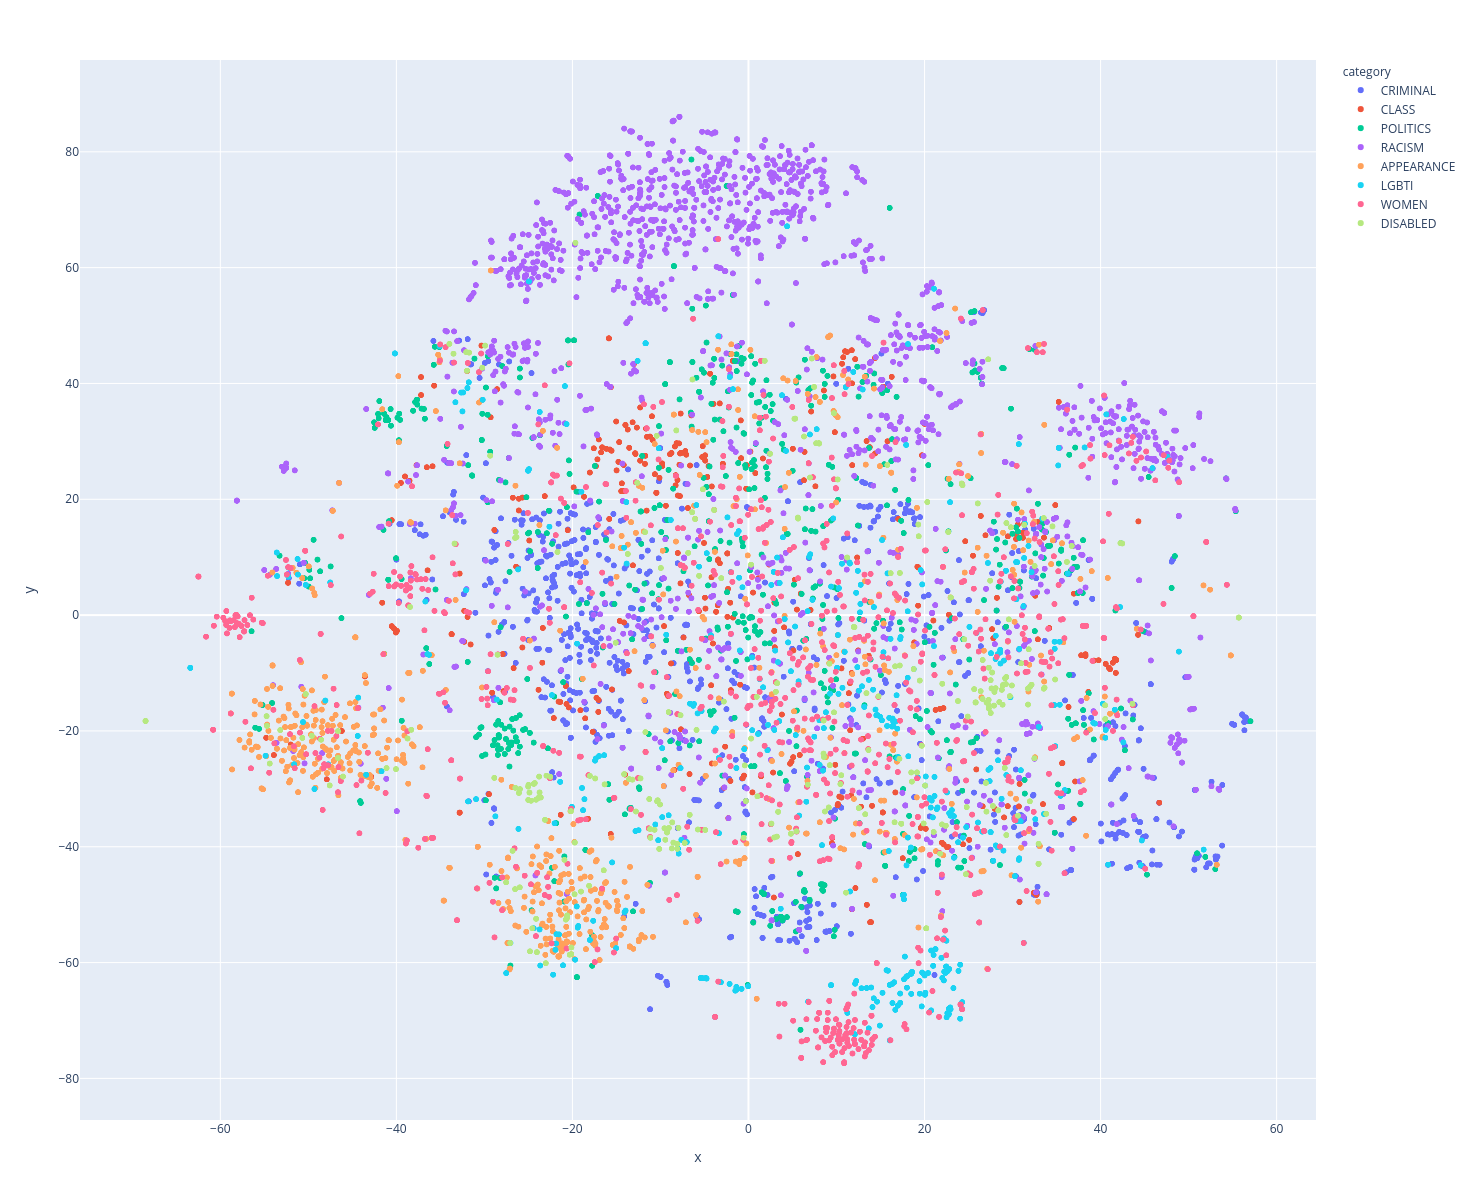

In [39]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y", hover_name="text", width=1200, height=1200, color="category")

fig.show()

## Con contexto

In [41]:
text = [ex["context"] + " [SEP] " + ex["text"] for ex in hateful_messages]
context_embeddings = model.encode(text)

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE()

projections = tsne.fit_transform(context_embeddings)

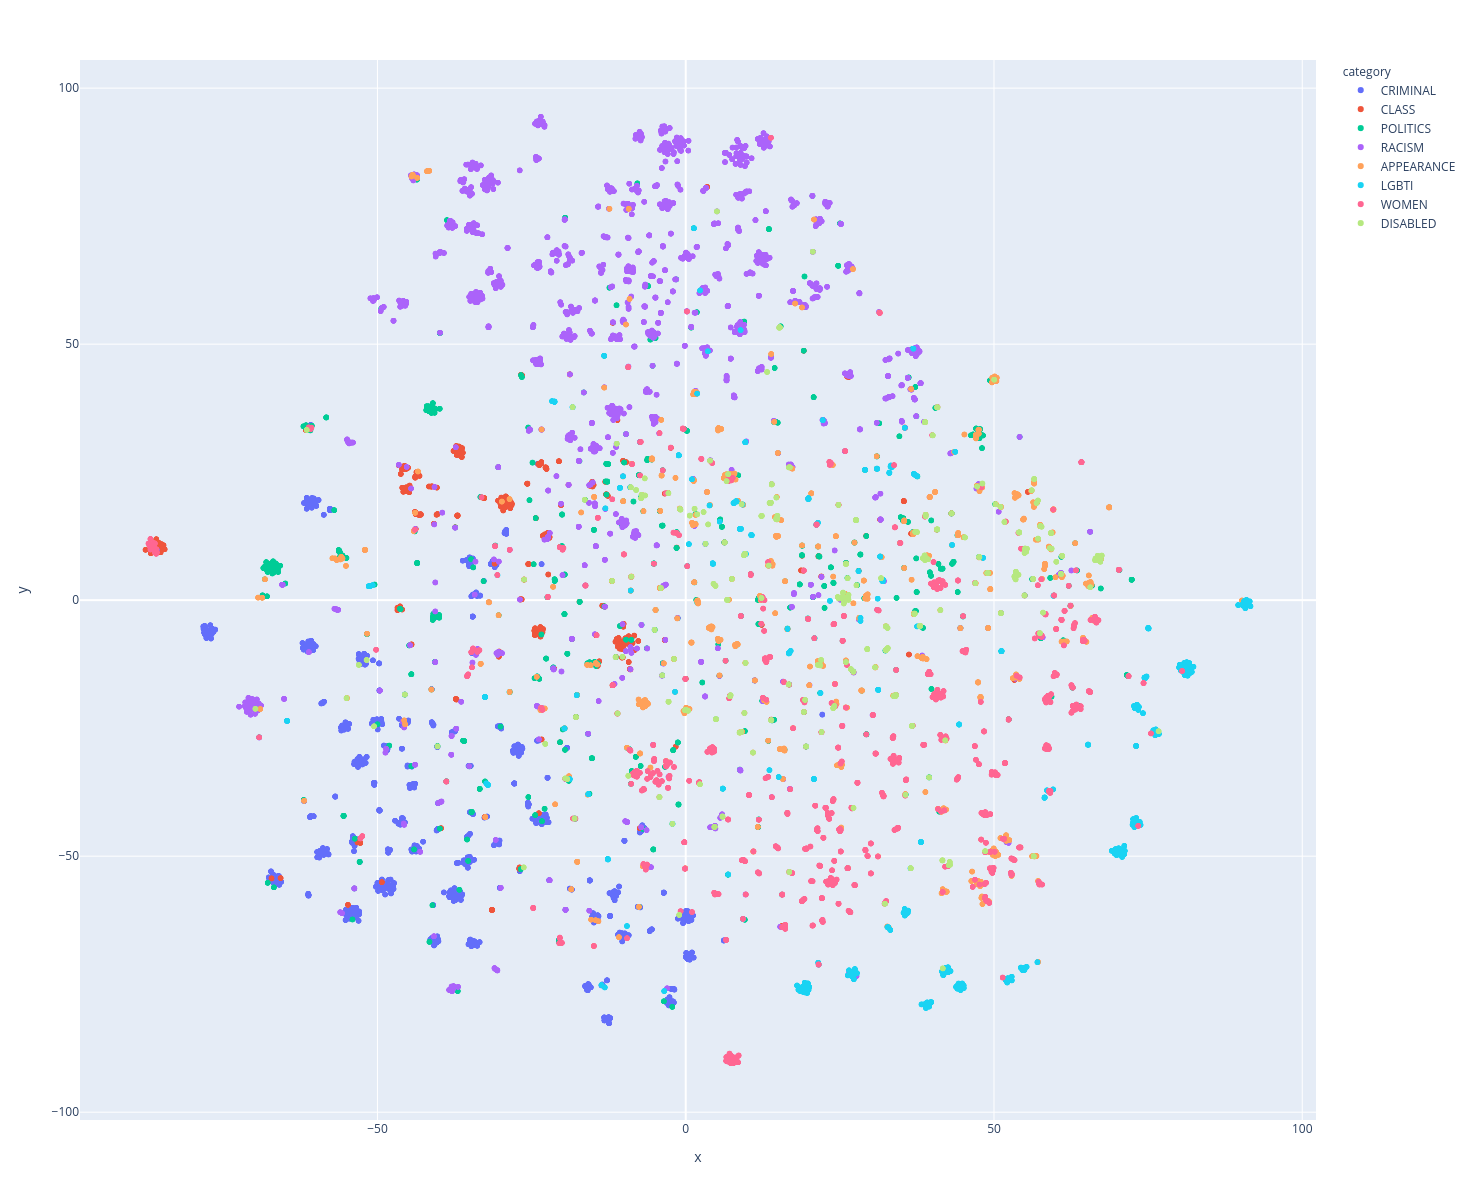

In [43]:
import pandas as pd
context_df = pd.DataFrame(projections, columns=["x", "y"])

context_df["text"] = text
context_df["category"] = categories

fig = px.scatter(context_df, x="x", y="y", hover_name="text", width=1200, height=1200, color="category")

fig.show()

Se agrupan feito

## Con umap

In [54]:
from umap import UMAP
import plotly.express as px

umap_2d = UMAP(n_components=2, init='random', random_state=2021)


umap_embeddings = umap_2d.fit_transform(embeddings)

In [55]:
import pandas as pd
df = pd.DataFrame(umap_embeddings, columns=["x", "y"])

df["text"] = text
df["category"] = categories

df

x         y                                               text  \
0     13.720137 -0.767794                                  usuario Uno menos   
1     10.874218 -1.357648                 usuario Seguimos alimentando vagos   
2      5.168643  2.198770  usuario lastima que no murio... necesitamos un...   
3      9.882336 -1.177946    usuario usuario Al fin se fue el pata sucia!!!!   
4      8.184278  2.594413  usuario Justo cuando salio de su programa de r...   
...         ...       ...                                                ...   
5526   2.387167  7.232830  usuario Cierren las fronteras, que no entre un...   
5527   9.998689  5.229787  usuario Q asco q es la gorda,a quien le puede ...   
5528  10.956216  3.086236  usuario Está bueno en parte, pueden hablar de ...   
5529   9.144219  1.099326  usuario Pero que gran noticia. Vamos zurditos,...   
5530  10.323745 -2.936531                        usuario Me parece excelente   

        category  
0       CRIMINAL  
1          CLASS  
2       POLITICS  
3         RACISM  
4       POLITICS  
...          ...  
5526      RACISM  
5527  APPEARANCE  
5528       LGBTI  
5529    POLITICS  
5530      RACISM  

[5531 rows x 4 columns]

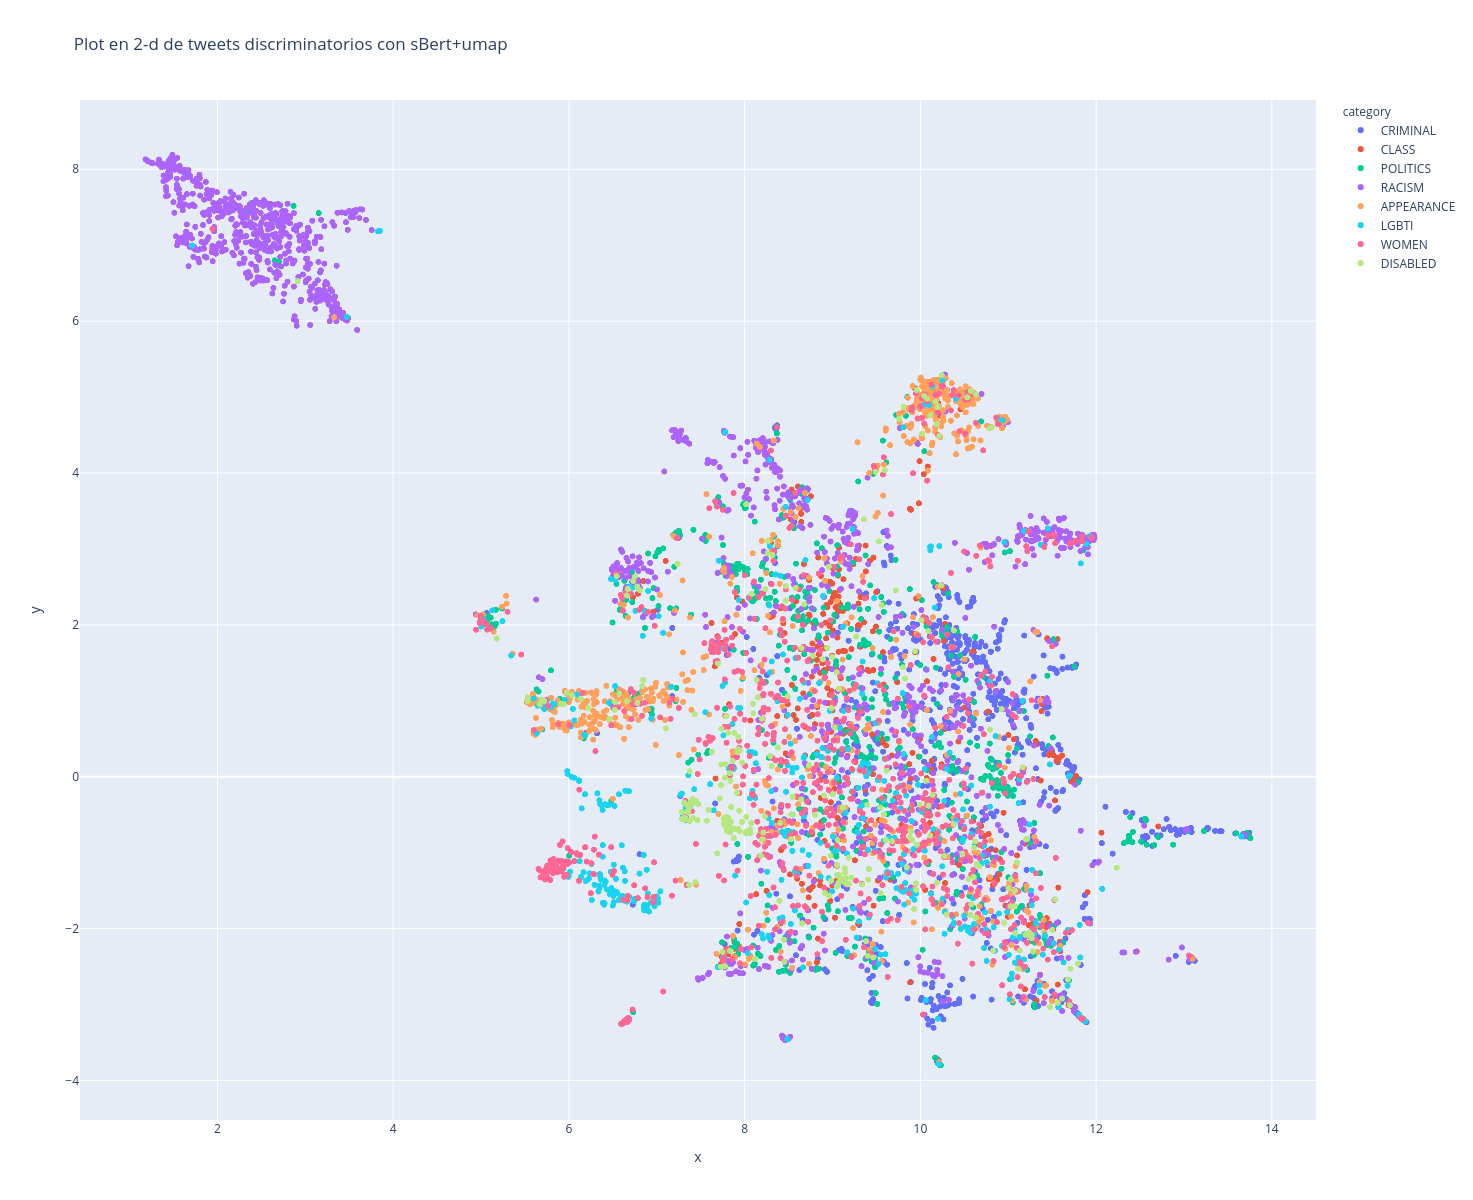

In [60]:
import plotly.express as px

fig = px.scatter(df, x="x", y="y", hover_name="text", width=1200, height=1200, color="category", title="Plot en 2-d de tweets discriminatorios con sBert+umap")

fig.show()

In [62]:
with open("sbert_umap_hateful_tweets.html", "w+") as f:
    f.write(fig.to_html(include_plotlyjs="cdn"))